# Test alignment parsing by `Targets`
This Jupyter notebook is designed to test parsing of alignments by `Targets`.

## Import Python modules

In [14]:
import contextlib
import os
import random
import re
import tempfile

from IPython.display import display

import pandas as pd

import yaml

import alignparse.minimap2
import alignparse.targets

## Set up `Targets`
Read in the RecA target used in the notebook examples:

There is just one target: ['RecA_PacBio_amplicon']
It has the following features: ['termini5', 'gene', 'spacer', 'barcode', 'termini3', 'variant_tag5', 'variant_tag3']


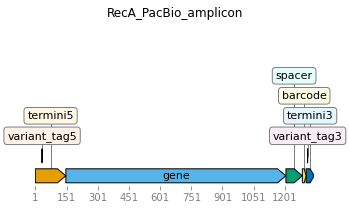

In [15]:
targetfile = "../notebooks/input_files/recA_amplicon.gb"
feature_parse_specs_file = "../notebooks/input_files/recA_feature_parse_specs.yaml"

with open(feature_parse_specs_file) as f:
    feature_parse_specs = yaml.safe_load(f)
# we can't get accuracies for the dummy alignments used here
feature_parse_specs["RecA_PacBio_amplicon"]["gene"]["return"] = "mutations"
feature_parse_specs["RecA_PacBio_amplicon"]["barcode"]["return"] = "sequence"

targets = alignparse.targets.Targets(
    seqsfile=targetfile,
    feature_parse_specs=feature_parse_specs,
    allow_extra_features=True,
)

print(f"There is just one target: {targets.target_names}")
target = targets.targets[0]

print(f"It has the following features: {target.feature_names}")

_ = targets.plot()

Location of features in 0-indexed scheme:

In [16]:
for feature in target.features:
    print(feature.name, feature.start, feature.end)

termini5 0 147
gene 147 1206
spacer 1206 1285
barcode 1285 1303
termini3 1303 1342
variant_tag5 32 33
variant_tag3 1310 1311


## Make some queries
We make some query sequences that we will align against the target.
The name of each query is a description of all ways that it differs from target:

In [17]:
random.seed(1)  # for reproducible output
nts = "ACGT"  # valid nucleotides


def randseq(length):
    """Random nucleotide sequence of given length."""
    return "".join(random.choices(nts, k=length))


def mutseq(wtseq):
    """Random mutant sequence from a wildtype sequence."""
    return "".join(random.choice([nt for nt in nts if nt != wt]) for wt in wtseq)


def get_wt_query(
    target, ambiguous_features=("barcode", "variant_tag5", "variant_tag3")
):
    """`(description, seq)` for wildtype query, ambiguous features assigned."""
    seq = target.seq
    description = []
    for fname in ambiguous_features:
        f = target.get_feature(fname)
        fseq = randseq(f.length)
        seq = seq[: f.start] + fseq + seq[f.end :]
        description.append(f"{f.name}={fseq}")
    assert len(seq) == len(target.seq)
    assert re.fullmatch(f"[{nts}]+", seq)
    return ",".join(description), seq


queries = []

# get two random (unmappable) queries
queries.append(("unmapped_1", randseq(target.length)))
queries.append(("unmapped_2", randseq(target.length // 2)))

# get a fully wildtype query
queries.append(get_wt_query(target))

# query with query clipping at both ends and a codon substitution in gene
desc, seq = get_wt_query(target)
# add substitution to gene
gene = target.get_feature("gene")
geneseq = gene.seq
mutstart = 6
mutlength = 3
mutcodon = mutseq(gene.seq[mutstart : mutstart + mutlength])
sub_desc = []
for i in range(mutlength):
    wt = geneseq[i + mutstart]
    mut = mutcodon[i]
    sub_desc.append(f"{wt}{mutstart + i}{mut}")
    geneseq = geneseq[: mutstart + i] + mut + geneseq[mutstart + i + 1 :]
seq = seq[: gene.start] + geneseq + seq[gene.end :]
desc += f",gene_{'-'.join(sub_desc)}"
# add clipping
desc += ",query_clip5=9"
seq = randseq(9) + seq
desc += ",query_clip3=7"
seq += randseq(7)
# add to list of queries
queries.append((desc, seq))

# query with a deletion in gene and in insertion in spacer
desc, seq = get_wt_query(target)
delstart = 7
dellength = 15
geneseq = gene.seq[:delstart] + gene.seq[delstart + dellength :]
spacer = target.get_feature("spacer")
insstart = 4
ins = "G"
spacerseq = spacer.seq[:insstart] + ins + spacer.seq[insstart:]
seq = (
    seq[: gene.start]
    + geneseq
    + seq[gene.end : spacer.start]
    + spacerseq
    + seq[spacer.end :]
)
desc += f",gene_del{delstart}to{delstart + dellength}"
desc += f",spacer_ins{insstart}{ins}"
queries.append((desc, seq))

# query with deletion spanning gene and spacer
desc, seq = get_wt_query(target)
delstartgene = gene.length - 7
delendgene = delstartgene + 7
geneseq = gene.seq[:delstartgene]
delendspacer = 9
spacerseq = spacer.seq[delendspacer:]
seq = seq[: gene.start] + geneseq + spacerseq + seq[spacer.end :]
desc += f",gene_del{delstartgene}to{delendgene},spacer_del1to{delendspacer}"
queries.append((desc, seq))

# query with insertion at boundary of gene and spacer, note how
# it is assigned as being at end of gene
desc, seq = get_wt_query(target)
ins = randseq(14)
seq = seq[: gene.end] + ins + seq[spacer.start :]
desc += f",gene_ins{gene.length}{ins}"
queries.append((desc, seq))

# query with target clipping at both ends
desc, seq = get_wt_query(target)
target_clip5 = target.get_feature("termini5").length + 4
target_clip3 = 2
seq = seq[target_clip5:-target_clip3]
desc = desc.split(",")
desc = ",".join([desc[0], "variant_tag5=None", desc[2]])
desc += f",target_clip5={target_clip5},target_clip3={target_clip3}"
desc += ",termini5=None,gene=<clip4>,termini3=<clip2>"
queries.append((desc, seq))

## Align the queries to the target

In [18]:
# NBVAL_IGNORE_OUTPUT

mapper = alignparse.minimap2.Mapper(alignparse.minimap2.OPTIONS_CODON_DMS)

with contextlib.ExitStack() as stack:

    # write queries to FASTA file
    queryfile = tempfile.NamedTemporaryFile("r+", suffix=".fasta")
    queryfile.write("\n".join(f">{desc}\n{seq}" for desc, seq in queries))
    queryfile.flush()

    # align the queries to the target
    alignmentfile = tempfile.NamedTemporaryFile("r+", suffix=".sam")
    targets.align(queryfile.name, alignmentfile.name, mapper)

    # get the alignment cs data frame
    alignments_cs = targets._parse_alignment_cs(alignmentfile.name)

    # get the alignment results
    readstats, aligned, filtered = targets.parse_alignment(alignmentfile.name)

## Check results of `Targets._parse_alignment_cs`
We now check if the feature-specific `cs` strings returned by `Targets._parse_alignment_cs` are correct.

We expect there to be alignments for just our one target plus the number of unmapped reads:

In [19]:
sorted(alignments_cs.keys()) == [target.name, "unmapped"]

True

Make sure the number of unmapped queries equals the number we passed in:

In [20]:
unmapped_queries = [(desc, query) for desc, query in queries if "unmapped" in desc]
len(unmapped_queries) == alignments_cs["unmapped"]

True

Make sure we get the expected queries mapped to our target:

In [21]:
mapped_queries = [tup for tup in queries if tup not in unmapped_queries]
len(mapped_queries) == len(alignments_cs[target.name])

True

Now we look manually at whether we got the expected `cs` strings for features:

In [22]:
with pd.option_context("display.max_colwidth", 70, "display.max_columns", None):
    display(alignments_cs[target.name])

,query_name,query_clip5,query_clip3,termini5_cs,termini5_clip5,termini5_clip3,gene_cs,gene_clip5,gene_clip3,spacer_cs,spacer_clip5,spacer_clip3,barcode_cs,barcode_clip5,barcode_clip3,termini3_cs,termini3_clip5,termini3_clip3,variant_tag5_cs,variant_tag5_clip5,variant_tag5_clip3,variant_tag3_cs,variant_tag3_clip5,variant_tag3_clip3
0,"barcode=CTAACTCGAGCTGCAATG,variant_tag5=A,variant_tag3=T",0,0,:32*na:114,0,0,:1059,0,0,:79,0,0,*nc*nt*na*na*nc*nt*nc*ng*na*ng*nc*nt*ng*nc*na*na*nt*ng,0,0,:7*nt:31,0,0,*na,0,0,*nt,0,0
1,"barcode=ACTAAAACCCACCGCGCT,variant_tag5=A,variant_tag3=C,gene_A6G-...",9,7,:32*na:114,0,0,:6*ag*ta*cg:1050,0,0,:79,0,0,*na*nc*nt*na*na*na*na*nc*nc*nc*na*nc*nc*ng*nc*ng*nc*nt,0,0,:7*nc:31,0,0,*na,0,0,*nc,0,0
2,"barcode=GTTACGACACGTTATTTC,variant_tag5=T,variant_tag3=C,gene_del7...",0,0,:32*nt:114,0,0,:7-tcgacgaaaacaaac:1037,0,0,:4+g:75,0,0,*ng*nt*nt*na*nc*ng*na*nc*na*nc*ng*nt*nt*na*nt*nt*nt*nc,0,0,:7*nc:31,0,0,*nt,0,0,*nc,0,0
3,"barcode=TAGTCTGTATCATAACTT,variant_tag5=A,variant_tag3=T,gene_del1...",0,0,:32*na:114,0,0,:1052-agatttt,0,0,-taatcgtct:70,0,0,*nt*na*ng*nt*nc*nt*ng*nt*na*nt*nc*na*nt*na*na*nc*nt*nt,0,0,:7*nt:31,0,0,*na,0,0,*nt,0,0
4,"barcode=TACCCTTGCTAAGTACGC,variant_tag5=T,variant_tag3=G,gene_ins1...",0,0,:32*nt:114,0,0,:1059+gggataggagacta,0,0,:79,0,0,*nt*na*nc*nc*nc*nt*nt*ng*nc*nt*na*na*ng*nt*na*nc*ng*nc,0,0,:7*ng:31,0,0,*nt,0,0,*ng,0,0
5,"barcode=GCGTCACAAGTGCCGAAT,variant_tag5=None,variant_tag3=T,target...",0,0,,147,0,:1055,4,0,:79,0,0,*ng*nc*ng*nt*nc*na*nc*na*na*ng*nt*ng*nc*nc*ng*na*na*nt,0,0,:7*nt:29,0,2,,1,0,*nt,0,0


## Check results of `Targets.parse_alignment`
Now check the results or `Targets.parse_alignment`.

First make sure the read stats are correct.
Here are those read stats:

In [23]:
readstats

,category,count
0,aligned RecA_PacBio_amplicon,3
1,filtered RecA_PacBio_amplicon,3
2,unmapped,2


Make sure they are correct for number of unmapped reads:

In [24]:
readstats.set_index("category")["count"].to_dict()["unmapped"] == len(unmapped_queries)

True

Now look at the filtered reads and make sure that they are what we expect:

In [25]:
with pd.option_context("display.max_colwidth", 70, "display.max_columns", None):
    display(filtered[target.name])

,query_name,filter_reason
0,"barcode=ACTAAAACCCACCGCGCT,variant_tag5=A,variant_tag3=C,gene_A6G-...",query_clip5
1,"barcode=TAGTCTGTATCATAACTT,variant_tag5=A,variant_tag3=T,gene_del1...",spacer mutation_nt_count
2,"barcode=GCGTCACAAGTGCCGAAT,variant_tag5=None,variant_tag3=T,target...",termini5 clip5


Check that the aligned reads are also what we expect:

In [26]:
with pd.option_context("display.max_colwidth", 70, "display.max_columns", None):
    display(aligned[target.name])

,query_name,query_clip5,query_clip3,gene_mutations,barcode_sequence,variant_tag5_sequence,variant_tag3_sequence
0,"barcode=CTAACTCGAGCTGCAATG,variant_tag5=A,variant_tag3=T",0,0,,CTAACTCGAGCTGCAATG,A,T
1,"barcode=GTTACGACACGTTATTTC,variant_tag5=T,variant_tag3=C,gene_del7...",0,0,del8to22,GTTACGACACGTTATTTC,T,C
2,"barcode=TACCCTTGCTAAGTACGC,variant_tag5=T,variant_tag3=G,gene_ins1...",0,0,ins1060GGGATAGGAGACTA,TACCCTTGCTAAGTACGC,T,G
